# Clustering with k-Means Model

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. 

Goal: Create 12 clusters of them

**NOTE:** The dataset is in a large CSV file called *minute_weather.csv*. The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg 

## Importing the libraries

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import utils
from sklearn import metrics
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
from itertools import cycle,islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

## Minute Weather Data Description

The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [2]:
data = pd.read_csv('./weather/minute_weather.csv')

In [3]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [4]:
# check missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)

dataMissing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
dataMissing.head(15)

,Total,Percent
min_wind_speed,433,0.027280
min_wind_direction,433,0.027280
max_wind_speed,433,0.027280
max_wind_direction,433,0.027280
avg_wind_speed,433,0.027280
avg_wind_direction,433,0.027280
rain_duration,1,0.000063
rain_accumulation,1,0.000063
relative_humidity,0,0.000000
air_temp,0,0.000000


In [5]:
data.shape

(1587257, 13)

## Data Sampling
Get every 10th row

In [6]:
dfTen = data[data['rowID'] % 10 == 0]
dfTen.shape

(158726, 13)

In [7]:
dfTen.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
10,10,2011-09-10 00:10:49,912.3,62.24,144.0,1.2,167.0,1.8,115.0,0.6,0.0,0.0,38.5
20,20,2011-09-10 00:20:49,912.2,63.32,100.0,2.0,122.0,2.5,91.0,1.5,0.0,0.0,58.3
30,30,2011-09-10 00:30:49,912.2,62.60,91.0,2.0,103.0,2.4,71.0,1.4,0.0,0.0,57.9
40,40,2011-09-10 00:40:49,912.2,64.04,81.0,2.6,88.0,2.9,68.0,1.4,0.0,0.0,57.4


## Statistics

In [8]:
dfTen.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [9]:
dfTen[dfTen['rain_accumulation'] == 0].shape

(157812, 13)

In [10]:
dfTen[dfTen['rain_duration'] == 0].shape

(157237, 13)

## Dropping all the rows with empty rain_duration and rain_accumulation

In [11]:
del dfTen['rain_accumulation']
del dfTen['rain_duration']

In [12]:
print('Rows before: ' + str(dfTen.shape[0]))
dfTen = dfTen.dropna()
print('Rows after: ' + str(dfTen.shape[0]))

Rows before: 158726
Rows after: 158680


**Lost 0.3% of dataframe**

In [13]:
dfTen.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

## Select features of interest for clustering

In [14]:
features = ['air_pressure', 'air_temp', 
            'avg_wind_direction', 'avg_wind_speed', 
            'max_wind_direction', 'max_wind_speed',
            'relative_humidity'
           ]

In [15]:
df = dfTen[features]
df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


## Scaling the features using StandardScaler

In [16]:
X = StandardScaler().fit_transform(df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

## The Elbow Method

In [17]:
def elbowMethod(data,maxK):
    distortions = []
    K = range(1,maxK)
    for k in K:
        model = KMeans(n_clusters=k).fit(data)
        model.fit(data)
        distortions.append(sum(np.min(cdist(data,model.cluster_centers_,'euclidean'),axis=1)) / data.shape[0])
    
    plt.plot(K,distortions,'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

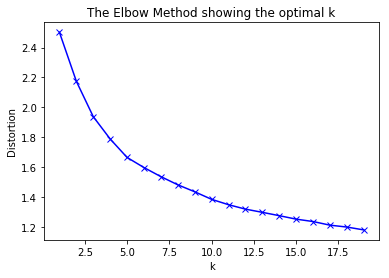

In [18]:
elbowMethod(X,20)

**k = 5 seems to be a good choice**

## Using k-Means Clustering

**For k = 12**

In [19]:
kmeans12 = KMeans(n_clusters = 12)
model12 = kmeans12.fit(X)
centers12 = model12.cluster_centers_
print('model\n',model12)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


**For k = 5**

In [20]:
kmeans5 = KMeans(n_clusters = 5)
model5 = kmeans5.fit(X)
centers5 = model5.cluster_centers_
print('model\n',model5)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


## Plots

In [21]:
# Function that creates a DataFrame with a column for Cluster Number
def pd_centers(features,centers):
    colNames = list(features)
    colNames.append('prediction')
    
    Z = [np.append(A,index) for index,A in enumerate(centers)]
    
    P = pd.DataFrame(Z,columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [22]:
# Function that creates Parallel Plots
def parallel_plot(data,k):
    myColors = list(islice(cycle(['b','r','g','y','k']), None, len(data)))
    plt.figure(figsize=(10,5)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data,'prediction',color = myColors,marker='o')
    plt.title('For k = ' + str(k))

In [23]:
plot5 = pd_centers(features, centers5)
plot12 = pd_centers(features, centers12)

## Dry Days

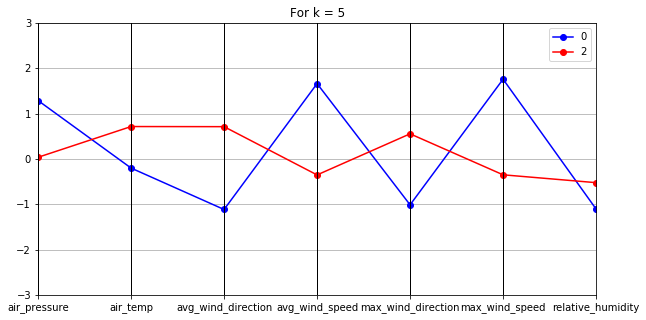

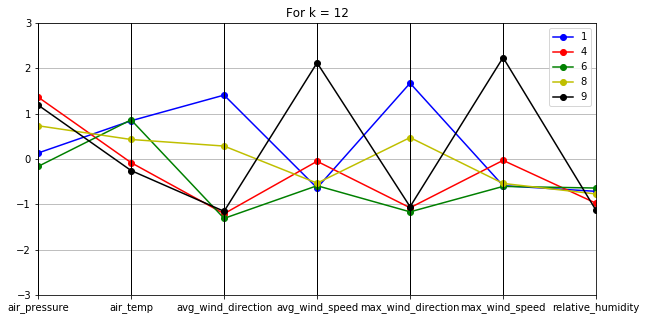

In [24]:
parallel_plot(plot5[plot5['relative_humidity'] < -0.5],5)
parallel_plot(plot12[plot12['relative_humidity'] < -0.5],12)

## Warm Days

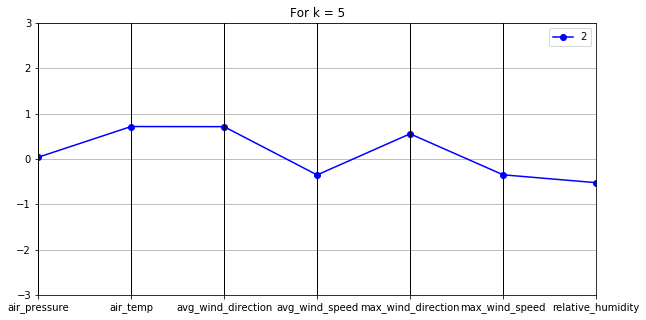

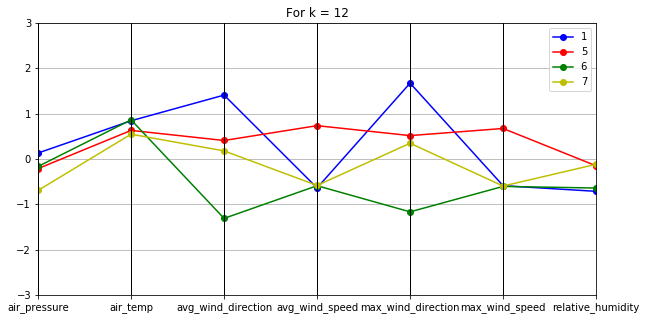

In [25]:
parallel_plot(plot5[plot5['air_temp'] > 0.5],5)
parallel_plot(plot12[plot12['air_temp'] > 0.5],12)

## Cool Days

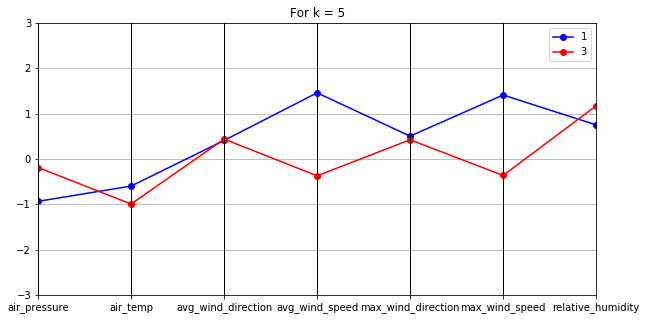

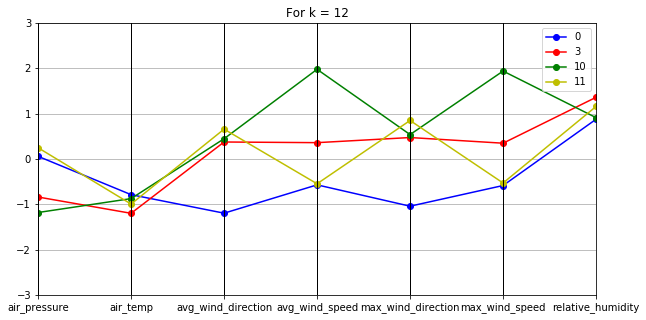

In [27]:
parallel_plot(plot5[(plot5['relative_humidity'] > 0.5) & (plot5['air_temp'] < 0.5)],5)
parallel_plot(plot12[(plot12['relative_humidity'] > 0.5) & (plot12['air_temp'] < 0.5)],12)